# Listing Price Regression Models Selection and Fine-Tuning

In [497]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import re
import warnings
import joblib
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

warnings.filterwarnings("ignore", category=FutureWarning)


# Listing Price Regression Models Selection and Fine-Tuning

## Overview

This script performs the following tasks:

1. **Data Preprocessing**:
   - Loads and preprocesses data for listing price prediction.
   - Applies one-hot encoding and ordinal encoding to categorical features.
   - Scales numerical features using MinMaxScaler.

2. **Model Training and Evaluation**:
   - Trains and evaluates various regression models including Linear Regression, Decision Trees, Random Forests, AdaBoost, Gradient Boosting, Support Vector Machines, XGBoost, and K-Nearest Neighbors.
   - Evaluates models using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Root Mean Squared Log Error (RMSLE).
   - Performs Grid Search for hyperparameter tuning on Gradient Boosting Regressor and Ridge Regression models.

3. **Sample Weighting**:
   - Calculates sample weights based on target variable values and incorporates them into the model training.

4. **Model Selection**:
   - Selects significant features using stepwise selection for final model training.
   - Compares model performance and visualizes predictions versus actual values.


## Script Details

1. **Imports and Setup**:
   - Imports necessary libraries and suppresses warnings.

2. **Data Loading and Preprocessing**:
   - Loads data from a pickle file.
   - Sets the index to 'Listing ID' and processes features and target variable.

3. **Data Splitting**:
   - Splits data into training and testing sets.

4. **Encoding and Scaling**:
   - Applies one-hot encoding to categorical columns.
   - Applies ordinal encoding to specific columns.
   - Scales numerical features using MinMaxScaler.

5. **Model Training**:
   - Defines and trains several regression models.
   - Evaluates models and stores results in a DataFrame.
   - Adds baseline models for comparison.

6. **Hyperparameter Tuning**:
   - Performs Grid Search for Gradient Boosting and Ridge Regression models.
   - Prints the best parameters and scores.

7. **Feature Selection**:
   - Uses stepwise selection to determine significant features.
   - Fits and summarizes the final model based on selected features.


## Notes

- This script includes advanced model fine-tuning techniques and feature selection for optimal performance in predicting listing prices.
- Adjust parameter grids and encoding methods as needed based on specific use cases or data characteristics.


In [498]:
model_reg_df = pd.read_pickle('step_5_df.pkl')
model_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12583 entries, 0 to 12582
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Listing ID                    12583 non-null  float64
 1   Host Response Time            12583 non-null  string 
 2   Host Response Rate            12583 non-null  float64
 3   neighbourhood                 12583 non-null  string 
 4   Neighborhood Group            12583 non-null  string 
 5   Latitude                      12583 non-null  float64
 6   Longitude                     12583 non-null  float64
 7   Room Type                     12583 non-null  string 
 8   Accomodates                   12583 non-null  float64
 9   Bathrooms                     12583 non-null  float64
 10  Bedrooms                      12583 non-null  float64
 11  Beds                          12583 non-null  float64
 12  Guests Included               12583 non-null  float64
 13  M

In [499]:
# Load and preprocess data
model_reg_df.set_index('Listing ID', inplace=True)
model_reg_df.columns = model_reg_df.columns.str.translate(str.maketrans('', '', string.punctuation))
y = np.log(model_reg_df['Price']) # Target variable
X = model_reg_df.drop('Price', axis=1)  # Features
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

X.shape

(12583, 56)

In [500]:
# Check for prices below zero
negative_prices = y[y < 0]

# Output the result
if negative_prices.empty:
    print("No prices below zero found.")
else:
    print(f"Prices below zero found: \n{negative_prices}")
y.describe()


No prices below zero found.


count    12583.000000
mean         3.893655
std          0.589873
min          0.000000
25%          3.465736
50%          3.871201
75%          4.248495
max          9.104980
Name: Price, dtype: float64

In [501]:
# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### get_dummies

In [502]:
# Define columns to be one-hot encoded
columns_to_encode = ['Host Response Time','Room Type','Bedrooms Binned', 
                      'Guests Included Binned', 'Bathrooms Binned', 'Min Nights Binned','Accomodates Binned', 'Beds Binned', 'Top10Neighbourhood', 'Neighborhood Group']

# Apply one-hot encoding to training data
X_train = pd.get_dummies(X_train, columns=columns_to_encode, drop_first=True)

# Apply one-hot encoding to test data using the same columns as training data
X_test = pd.get_dummies(X_test, columns=columns_to_encode, drop_first=True)


#X_train.info()


### OrdinalEncoder

In [504]:
# Define columns to be label encoded
columns_to_encode = ['neighbourhood']

# Initialize OrdinalEncoder
ordinal_encoders = {}

# Function to apply ordinal encoding with handling unseen labels
def apply_ordinal_encoding(train_df, test_df, columns):
    for col in columns:
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        # Fit encoder on training data
        train_df[col + '_Encoded'] = oe.fit_transform(train_df[[col]])
        
        # Encode test data, handling unseen labels
        test_df[col + '_Encoded'] = oe.transform(test_df[[col]])
        
        # Store the encoder if needed for future reference
        ordinal_encoders[col] = oe
    
    return train_df, test_df

# Apply encoding to training and test data
X_train, X_test = apply_ordinal_encoding(X_train, X_test, columns_to_encode)

# Optionally, drop the original columns if they are no longer needed
X_train.drop(columns=columns_to_encode, inplace=True)
X_test.drop(columns=columns_to_encode, inplace=True)


X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10066 entries, 7291047.0 to 30681281.0
Data columns (total 94 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Host Response Rate                           10066 non-null  float64
 1   Latitude                                     10066 non-null  float64
 2   Longitude                                    10066 non-null  float64
 3   Accomodates                                  10066 non-null  float64
 4   Bathrooms                                    10066 non-null  float64
 5   Bedrooms                                     10066 non-null  float64
 6   Beds                                         10066 non-null  float64
 7   Guests Included                              10066 non-null  float64
 8   Min Nights                                   10066 non-null  float64
 9   Reviews                                      10066 non-null  flo

## MinMaxScaler

In [505]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns
numerical_cols = [ 'Host Response Rate', 'Latitude', 'Longitude',
                   'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included',
                   'Min Nights', 'Reviews', 'DistancetoCenter', 
                   'Days Since Last Joined', 'Review Range Days', 'Reviews per Day Ratio', 
                   'timediffreviews']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the numerical columns of the training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Use the scaler fitted on X_train to transform the numerical columns in X_test

X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Display descriptive statistics of X_train
#X_train.info()

# Model Selection

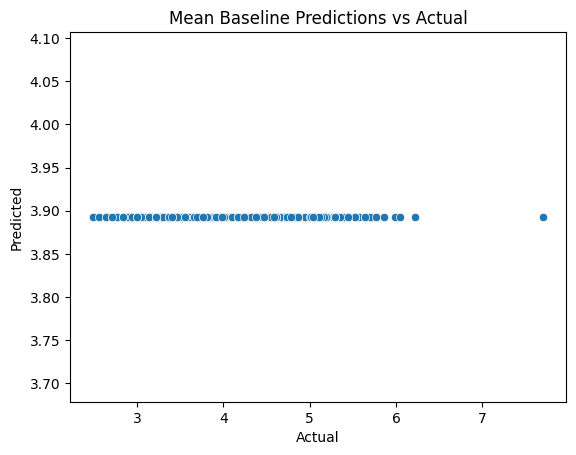

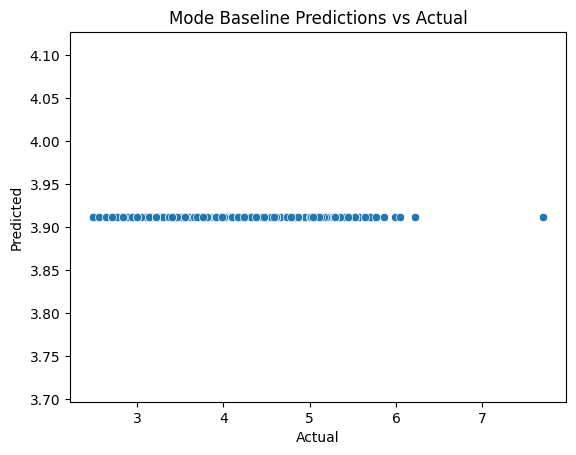

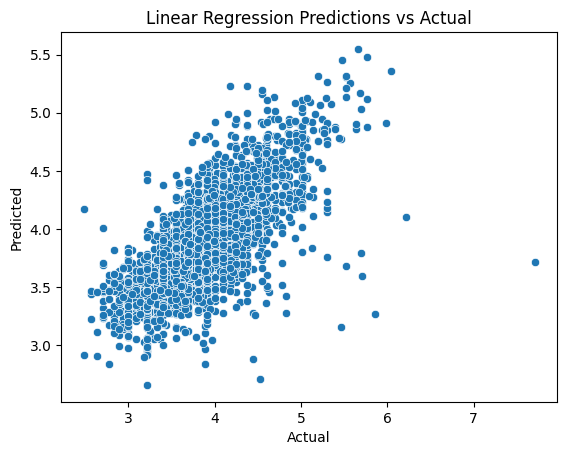

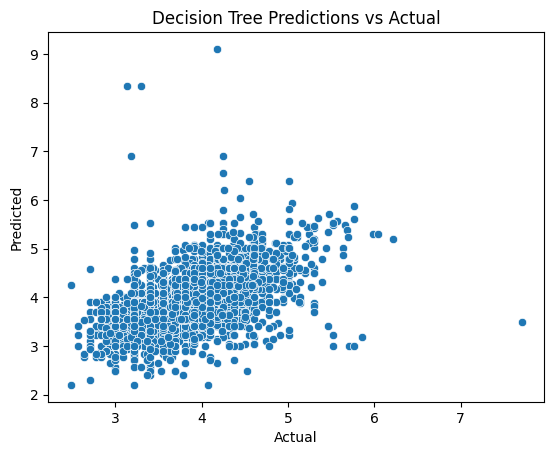

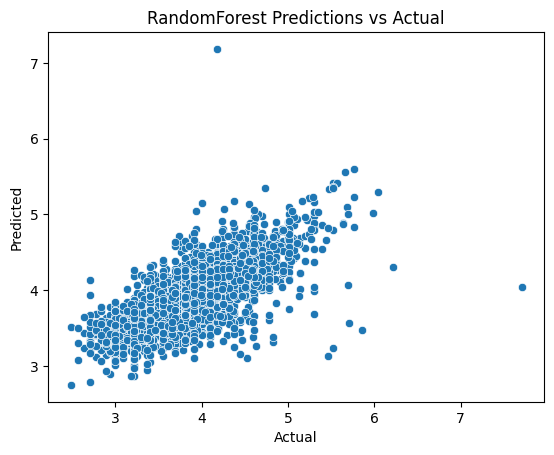

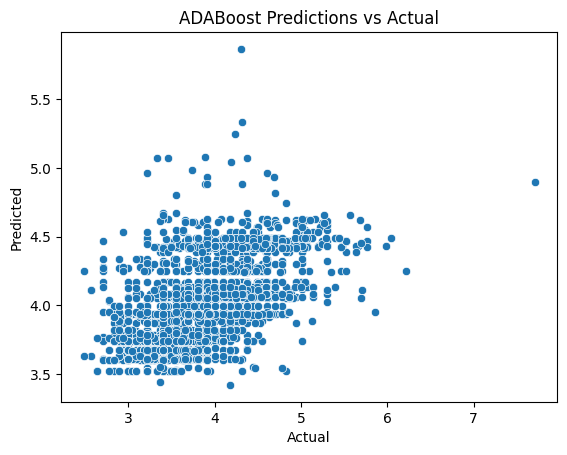

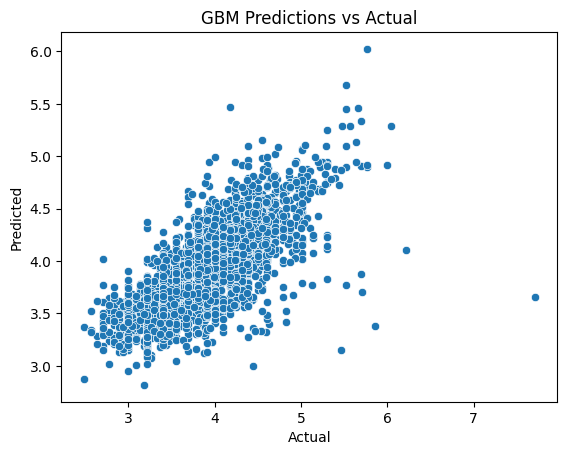

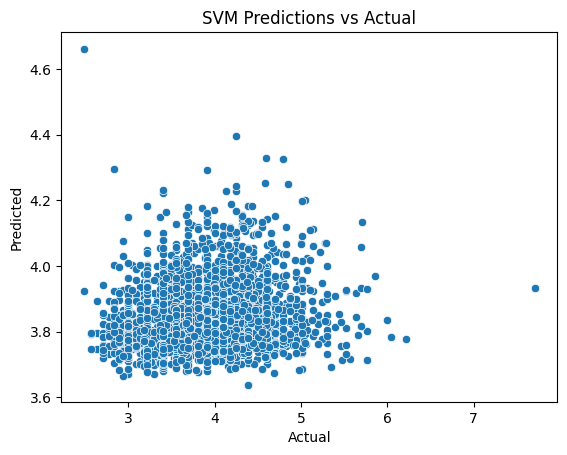

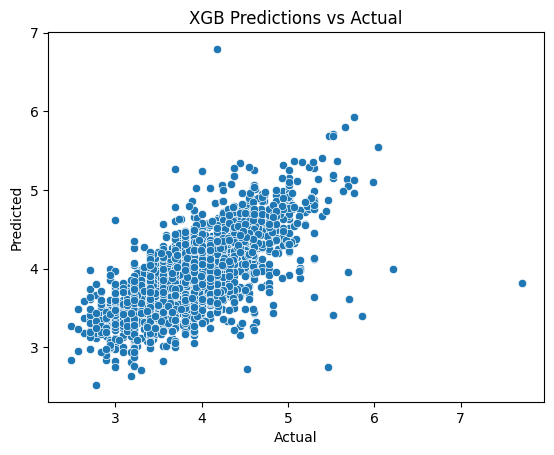

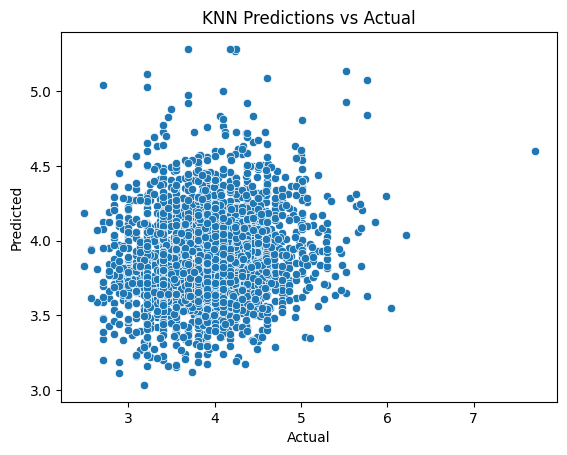

               Model      Test_MSE   Test_RMSE   Test_MAE  Test_RMSLE  \
2  Linear Regression   2770.161975   52.632328  18.151374    0.383330   
6                GBM   2780.154352   52.727169  18.118079    0.378006   
8                XGB   3060.060007   55.317809  18.890901    0.395193   
5           ADABoost   3099.430972   55.672533  23.849086    0.489397   
4       RandomForest   3353.931866   57.913141  18.559882    0.384123   
9                KNN   3637.385991   60.310745  28.611260    0.591703   
1      Mode Baseline   3650.160906   60.416562  27.027016    0.562670   
0      Mean Baseline   3668.914381   60.571564  27.016846    0.562589   
7                SVM   3681.490654   60.675289  26.562591    0.557177   
3      Decision Tree  50496.832737  224.715003  34.127135    0.570046   

   Test_MAPE  
2  30.122372  
6  29.891001  
8  31.575911  
5  47.878646  
4  31.001756  
9  53.554166  
1  49.469853  
0  48.511501  
7  45.361887  
3  67.616644  


In [523]:
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

# Function to calculate regression metrics
def regressionMetrics(y, yhat):
    residuals = y - yhat
    mse = metrics.mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y, yhat)
    rmsle = np.sqrt(metrics.mean_squared_log_error(y, yhat)) if (y > 0).all() and (yhat > 0).all() else np.nan
    
    # Calculate MAPE
    mape = np.mean(np.abs((y - yhat) / y)) * 100 if (y != 0).all() else np.nan
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'RMSLE': rmsle,
        'MAPE': mape
    }

# Initialize DataFrame to store model performance with appropriate columns
models_list = pd.DataFrame(columns=['Model', 'Test_MSE', 'Test_RMSE', 'Test_MAE', 'Test_RMSLE', 'Test_MAPE'])

# Function to train model and store results
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Fit the model on training data if it is not a baseline model
    if model is not None:
        model.fit(X_train, y_train)
        test_preds = model.predict(X_test)
    else:
        test_preds = y_train.mean() if model_name == "Mean Baseline" else y_train.mode()[0]
        test_preds = np.full_like(y_test, test_preds)  # Fill predictions with the mean or mode
    
    # Calculate metrics
    test_metrics = regressionMetrics(np.exp(y_test), np.exp(test_preds))
    
    # Store metrics in DataFrame
    results = pd.DataFrame([{
        'Model': model_name,
        'Test_MSE': test_metrics['MSE'],
        'Test_RMSE': test_metrics['RMSE'],
        'Test_MAE': test_metrics['MAE'],
        'Test_RMSLE': test_metrics['RMSLE'],
        'Test_MAPE': test_metrics['MAPE']
    }])
    
    # Concatenate results to the DataFrame
    global models_list
    models_list = pd.concat([models_list, results], ignore_index=True)
    
    # Optionally, visualize predictions
    sns.scatterplot(x=y_test, y=test_preds)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

# Add baseline models for comparison
train_and_evaluate_model(None, "Mean Baseline", X_train, y_train, X_test, y_test)
train_and_evaluate_model(None, "Mode Baseline", X_train, y_train, X_test, y_test)

# Train other models including KNN
models = [
    (LinearRegression(), "Linear Regression"),
    (DecisionTreeRegressor(random_state=1), "Decision Tree"),
    (RandomForestRegressor(random_state=1), "RandomForest"),
    (AdaBoostRegressor(random_state=1), "ADABoost"),
    (GradientBoostingRegressor(random_state=1), "GBM"),
    (SVR(), "SVM"),
    (xgb.XGBRegressor(), "XGB"),
    (KNeighborsRegressor(), "KNN")  # Added KNN
]

# Ensure all feature names are strings and clean up any invalid characters
X_train.columns = [re.sub(r'[\[\]<]', '', str(col)) for col in X_train.columns]
X_test.columns = [re.sub(r'[\[\]<]', '', str(col)) for col in X_test.columns]

for model, name in models:
    train_and_evaluate_model(model, name, X_train, y_train, X_test, y_test)

# Display results sorted by Test RMSE
models_list = models_list[['Model', 'Test_MSE', 'Test_RMSE', 'Test_MAE', 'Test_RMSLE', 'Test_MAPE']]
print(models_list.sort_values('Test_RMSE'))


# Model Tuning

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\Gil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
594 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Gil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Gil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Gil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", l

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (MSE): 0.172715387950896
Test MSE: 0.15901432975499272


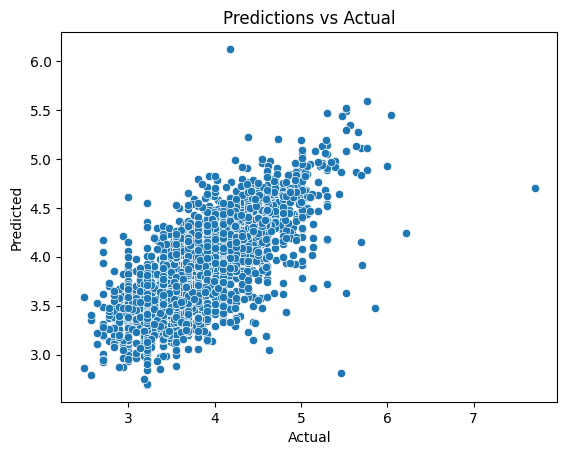

In [474]:
# Define sample weights
def calculate_sample_weights(y):
    return np.where(y > 4.19, 5, 1)  # Assign higher weight (e.g., 5) if y > 4.19, otherwise weight (e.g., 1)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the ensemble. More trees generally improve performance but increase computation time.
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split. 
                                              # 'auto' uses all features, 'sqrt' uses the square root of the number of features, 
                                              # and 'log2' uses the logarithm base 2 of the number of features.
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree. Deeper trees can capture more complex patterns but are prone to overfitting.
                                              # 'None' means nodes are expanded until all leaves are pure or contain less than min_samples_split samples.
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node. 
                                      # Higher values prevent overfitting by ensuring splits create meaningful branches.
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node. 
                                    # Higher values prevent overfitting by ensuring the leaves have enough samples.
}

# Initialize Gradient Boosting Regressor
model = GradientBoostingRegressor()

# Perform Grid Search with Cross-Validation
GBM_grid_search = GridSearchCV(estimator=model,  # Gradient Boosting model, which builds an ensemble of trees sequentially.
                               param_grid=param_grid,  # Grid of hyperparameters to test.
                               cv=3,  # Number of cross-validation folds; cv=3 means 3-fold cross-validation.
                               n_jobs=-1,  # Use all available CPU cores to perform the search.
                               verbose=2,  # Print detailed logs of the grid search process.
                               scoring='neg_mean_squared_error')  # Scoring metric; negative MSE is used because GridSearchCV minimizes the score.

# Calculate sample weights for training data
sample_weights = calculate_sample_weights(y_train)

# Fit the model on the training data with sample weights and grid search
GBM_grid_search.fit(X_train, y_train, sample_weight=sample_weights)

# Print best parameters and score
print("Best Parameters:", GBM_grid_search.best_params_)  # Outputs the combination of parameters that performed the best.
print("Best Score (MSE):", -GBM_grid_search.best_score_)  # Outputs the best (lowest) MSE found in the grid search.

# Evaluate fine-tuned model
best_model = GBM_grid_search.best_estimator_

# Calculate predictions
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

# Optional: Visualize predictions vs actual
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


#Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
#Best Score (MSE): 0.172715387950896
#Test MSE: 0.15901432975499272


In [487]:
preds_ft = best_model.predict(X_test)
models_list.loc[len(models_list)] = ["GBM_FT"] + list(regressionMetrics(np.exp(y_test), np.exp(preds_ft)).values())
print(models_list)


                Model      Test_MSE   Test_RMSE   Test_MAE  Test_RMSLE
0       Mean Baseline   3668.914381   60.571564  27.016846    0.562589
1       Mode Baseline   3650.160906   60.416562  27.027016    0.562670
2   Linear Regression   2770.161975   52.632328  18.151374    0.383330
3       Decision Tree  50496.832737  224.715003  34.127135    0.570046
4        RandomForest   3353.931866   57.913141  18.559882    0.384123
5            ADABoost   3099.430972   55.672533  23.849086    0.489397
6                 GBM   2780.154352   52.727169  18.118079    0.378006
7                 SVM   3681.490654   60.675289  26.562591    0.557177
8                 XGB   3060.060007   55.317809  18.890901    0.395193
9                 KNN   3637.385991   60.310745  28.611260    0.591703
10             GBM_FT   2693.438929   51.898352  18.457240    0.390430


In [ ]:
# Save the best model to a pickle file
joblib.dump(best_model, 'best_gbm_model.pkl')
print("Best model saved to 'best_gbm_model.pkl'")

#### MAPE (Mean Absolute Percentage Error) measures prediction accuracy as a percentage.  my best model, Gradient Boosting Machine (GBM), has a MAPE of 30%, this indicates that, on average, the model's predictions deviate by 30% from the actual values. This level of accuracy is not  sufficient for production use.

In [508]:
# Predict using the GBM 
preds_ft = best_model.predict(X_test)

# Create a DataFrame for predictions and actual values
results_df = pd.DataFrame({'Predicted': np.exp(preds_ft), 'Actual': np.exp(y_test)})

# Calculate deciles based on predicted values
results_df['Decile'] = pd.qcut(results_df['Predicted'], q=10, labels=False) + 1

# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Initialize a list to store RMSE and price range for each decile
decile_metrics_list = []

# Calculate RMSE and price range for each decile
for decile in range(1, 11):
    decile_data = results_df[results_df['Decile'] == decile]
    rmse = calculate_rmse(decile_data['Actual'], decile_data['Predicted'])
    price_range = (round(decile_data['Predicted'].min(), 2), round(decile_data['Predicted'].max(), 2))
    decile_metrics_list.append({'Decile': decile, 'RMSE': rmse, 'Price Range': price_range})

# Convert list to DataFrame
decile_metrics = pd.DataFrame(decile_metrics_list)

# Display RMSE and price ranges for each decile
print(decile_metrics)



   Decile        RMSE      Price Range
0       1   19.635443   (14.72, 28.46)
1       2   24.564986    (28.49, 33.6)
2       3   15.509786   (33.61, 37.44)
3       4   24.126556   (37.44, 42.77)
4       5   18.747476   (42.78, 49.04)
5       6   28.230716   (49.07, 56.84)
6       7   30.442727    (56.87, 66.4)
7       8   36.978947   (66.44, 75.84)
8       9   28.409555   (75.85, 92.18)
9      10  144.396983  (92.38, 457.73)


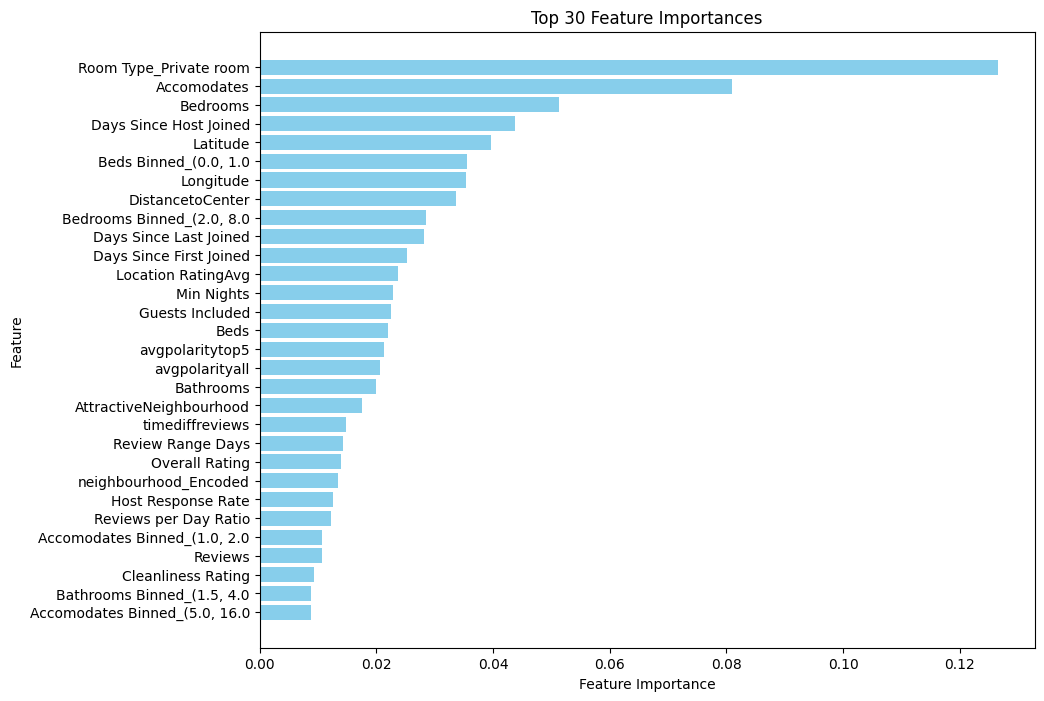

In [521]:
# Feature_importances
feature_importance = best_model.feature_importances_

# Create a DataFrame for the features and their importance
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 30 features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(30), importance_df['Importance'].head(30), color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importances')
plt.show()


In [387]:
# Create a pipeline with scaling and Ridge regression
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Scales features to a range, typically [0, 1].
    ('ridge', Ridge())  # Ridge regression model
])

# Define the parameter grid without 'normalize'
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0],  # Regularization strength; larger values specify stronger regularization.
    'ridge__max_iter': [None, 1000, 2000, 3000],  # Maximum number of iterations for the solver. None means no limit.
    'ridge__tol': [1e-4, 1e-3, 1e-2],  # Tolerance for the stopping criteria; lower values mean higher precision.
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']  # Solver algorithm to use. Different solvers may converge faster based on the problem.
}

# Perform grid search
ridge_grid_search = GridSearchCV(estimator=pipeline,  # The model pipeline that includes scaling and Ridge regression.
                           param_grid=param_grid,  # The grid of hyperparameters to search.
                           cv=3,  # Number of cross-validation folds. cv=3 means 3-fold cross-validation.
                           n_jobs=-1,  # Use all available CPU cores to perform the search.
                           verbose=2,  # Print detailed logs of the process.
                           scoring='neg_mean_squared_error')  # Scoring metric; here, negative MSE is used because GridSearchCV minimizes the score.
ridge_grid_search.fit(X_train, y_train)  # Fit the model on the training data with grid search.

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)  # Outputs the combination of parameters that performed the best.
print("Best Score (MSE):", -grid_search.best_score_)  # Outputs the best (lowest) MSE found in the grid search.



Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'ridge__alpha': 1.0, 'ridge__max_iter': 1000, 'ridge__solver': 'saga', 'ridge__tol': 0.01}
Best Score (MSE): 0.16684374151317807


In [489]:
preds_ft = ridge_grid_search.predict(X_test)
models_list.loc[len(models_list)] = ["ridge_FT"] + list(regressionMetrics(np.exp(y_test), np.exp(preds_ft)).values())
models_list=models_list.sort_values(by=['Test_RMSE', 'Test_RMSLE'])
print(models_list)


                Model      Test_MSE   Test_RMSE   Test_MAE  Test_RMSLE
10             GBM_FT   2693.438929   51.898352  18.457240    0.390430
11           ridge_FT   2763.707565   52.570976  18.098408    0.382093
12           ridge_FT   2763.707565   52.570976  18.098408    0.382093
2   Linear Regression   2770.161975   52.632328  18.151374    0.383330
6                 GBM   2780.154352   52.727169  18.118079    0.378006
8                 XGB   3060.060007   55.317809  18.890901    0.395193
5            ADABoost   3099.430972   55.672533  23.849086    0.489397
4        RandomForest   3353.931866   57.913141  18.559882    0.384123
9                 KNN   3637.385991   60.310745  28.611260    0.591703
1       Mode Baseline   3650.160906   60.416562  27.027016    0.562670
0       Mean Baseline   3668.914381   60.571564  27.016846    0.562589
7                 SVM   3681.490654   60.675289  26.562591    0.557177
3       Decision Tree  50496.832737  224.715003  34.127135    0.570046


In [ ]:
models_list.to_excel('models_list.xlsx', index=False)

In [ ]:
# Save the best model to a pickle file
joblib.dump(ridge_grid_search, 'ridge.pkl')
print("ridge saved to 'ridge_model.pkl'")

In [512]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Identify boolean columns
boolean_cols = X_train.select_dtypes(include='bool').columns

# Convert boolean columns to uint64
X_train[boolean_cols] = X_train[boolean_cols].astype('uint64')
# Convert all columns in X_train to numeric types, coercing errors into NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Stepwise selection function to select significant features
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=False):
    included = []  # Start with an empty list of included features
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))  # Features not yet included
        new_pval = pd.Series(index=excluded, dtype=float)
        # Test each excluded feature
        for col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [col]])).fit()
            new_pval[col] = model.pvalues[col]
        # Add feature with the lowest p-value below threshold_in
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            included.append(new_pval.idxmin())
            changed = True
            if verbose:
                print(f'Add {new_pval.idxmin()} with p-value {best_pval:.6f}')
        # Remove feature with the highest p-value above threshold_out
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude the constant's p-value
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            included.remove(pvalues.idxmax())
            changed = True
            if verbose:
                print(f'Drop {pvalues.idxmax()} with p-value {worst_pval:.6f}')
        # Stop if no changes
        if not changed:
            break
    return included

# Run stepwise selection to choose significant features
selected_features = stepwise_selection(X_train, y_train)

# Fit the final model using the selected features
final_model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()
print(final_model.summary())  # Print the regression summary

# Predict on the test set and calculate Adjusted R²
y_pred = final_model.predict(sm.add_constant(X_test[selected_features]))
r2_adj = 1 - (1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - len(selected_features) - 1)
print(f'Adjusted R²: {r2_adj:.4f}')  # Print the Adjusted R² to evaluate model performance


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     232.3
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:54:43   Log-Likelihood:                -5159.7
No. Observations:               10066   AIC:                         1.042e+04
Df Residuals:                   10015   BIC:                         1.079e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [522]:
# Get the p-values and coefficients of the features
p_values = final_model.pvalues[1:]  # Exclude the constant term
coefficients = final_model.params[1:]  # Exclude the constant term

# Create a DataFrame for features, their p-values, and coefficients
p_values_df = pd.DataFrame({
    'Feature': p_values.index, 
    'P-Value': p_values.values,
    'Coefficient': coefficients.values
})

# Calculate the percentage effect on the price
p_values_df['Approximate Percentage Effect on Price'] = (np.exp(p_values_df['Coefficient']) - 1) * 100

# Sort by absolute effect on price
p_values_df['Absolute Effect on Price'] = p_values_df['Approximate Percentage Effect on Price'].abs()
p_values_df = p_values_df.sort_values(by='Absolute Effect on Price', ascending=False)

# Drop the helper column used for sorting
p_values_df = p_values_df.drop(columns='Absolute Effect on Price')

# Display the table
print(p_values_df.to_string(index=False, float_format='{:.4f}'.format))


                               Feature  P-Value  Coefficient  Approximate Percentage Effect on Price
                Host Missing Indicator   0.0000       0.9806                                166.6147
                       Guests Included   0.0000       0.7682                                115.5934
                           Accomodates   0.0000       0.7132                                104.0532
                 Overall Ratingmissing   0.0000       0.5992                                 82.0621
                             Bathrooms   0.0000       0.4376                                 54.8924
                 Room Type_Shared room   0.0000      -0.6360                                -47.0570
                             Longitude   0.0000      -0.6162                                -46.0011
         Accomodates Binned_(5.0, 16.0   0.0000       0.3721                                 45.0820
          Accomodates Binned_(4.5, 5.0   0.0000       0.3304                               